# Energy vs Power cell example

This notebook shows how to use PyBaMM to simulate an energy cell vs a power cell by changing the thickness of the electrodes

First, we import the PyBaMM library and create a model for the lithium-ion DFN, together with the "Chen2020" parameter set, which is parameterized for a LGM50 cell.

In [1]:
import pybamm

model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues("Chen2020")

## Simple simulation

Now, let's run a simple simulation. This example requires the IDAKLUSolver, so make sure you use PyBaMM 25.1 so that it is available on whatever platform you are using.

In [2]:
solver = pybamm.IDAKLUSolver()
experiment = pybamm.Experiment(["Discharge at 1C until 2.5V"])
sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=experiment, solver=solver)
sol = sim.solve(initial_soc=1)

and look at the voltage response, as well as the power and energy at 1C

Mean power:  18.257668771568326 W
Energy:  17.503454322656733 Wh


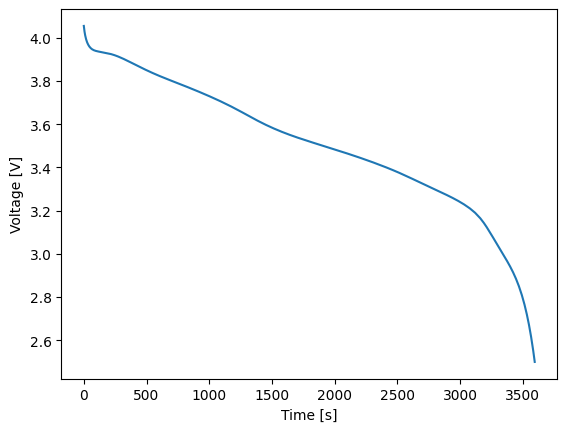

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
time = sol["Time [s]"].data
ax.plot(time, sol["Voltage [V]"].data)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")

power = sol["Power [W]"].data
energy = np.trapz(power, time / 3600)

print("Mean power: ", np.mean(power), "W")
print("Energy: ", energy, "Wh")

## Sweeping C-rate

By sweeping the C-rate, we can see how the power and energy change (higher C-rate means higher power and lower energy)

In [4]:
C_rates = [0.1, 0.2, 0.5, 1, 2, 3, 5, 10, 20]

def sweep_c_rate(C_rates, parameter_values):
    outputs = {"C-rate": C_rates, "Energy [Wh]": [], "Power [W]": []}
    for C_rate in C_rates:
        experiment = pybamm.Experiment([f"Discharge at {C_rate}C until 2.5V"])
        sim = pybamm.Simulation(
            model, parameter_values=parameter_values, experiment=experiment, solver=solver
        )
        sol = sim.solve(initial_soc=1)
        time = sol["Time [s]"].data
        power = sol["Power [W]"].data
        energy = np.trapz(power, time / 3600)
        outputs["Energy [Wh]"].append(energy)
        outputs["Power [W]"].append(np.mean(power))

    return outputs

outputs_energy_cell = sweep_c_rate(C_rates, parameter_values)

Text(0.5, 0.98, 'Energy cell')

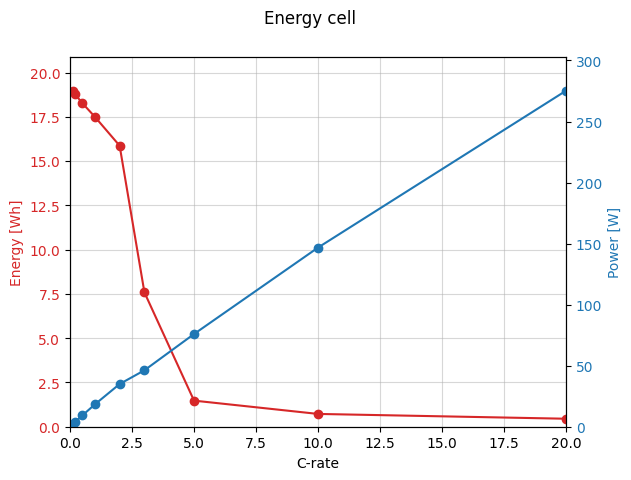

In [5]:
def plot_power_vs_energy(outputs):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_xlabel("C-rate")

    # change y axis labels and color to blue
    ax.plot(outputs["C-rate"], outputs["Energy [Wh]"], "-o", color="tab:red")
    ax.set_ylabel("Energy [Wh]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")
    ax.set_ylim(0, outputs["Energy [Wh]"][0] * 1.1)

    # add a twin axis for time on a log scale
    ax2.plot(outputs["C-rate"], outputs["Power [W]"], "-o", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Power [W]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])
    ax2.set_ylim(0, outputs["Power [W]"][-1] * 1.1)

    ax.grid(alpha=0.5)
    
    return fig, ax

fig, ax = plot_power_vs_energy(outputs_energy_cell)
fig.suptitle("Energy cell")


This is an energy cell with a maximum C-rate of 2C, so the energy drops off significantly as the C-rate increases above 2C

## Changing electrode thickness

We can also sweep the electrode thickness to see how the power and energy change. We will change the thickness of the positive electrode and the negative electrode proportionally to avoid having to change the N/P ratio and electrode balance.

Text(0.5, 0.98, 'Power cell')

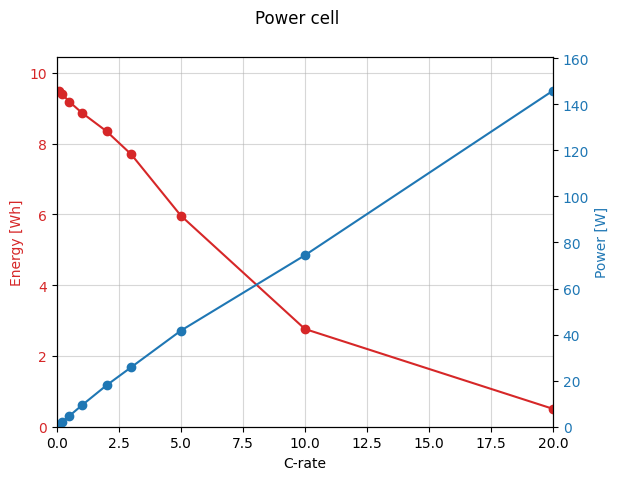

In [6]:
parameter_values_power_cell = pybamm.ParameterValues("Chen2020")
parameter_values_power_cell["Negative electrode thickness [m]"] *= 1/2
parameter_values_power_cell["Positive electrode thickness [m]"] *= 1/2
# Change the nominal cell capacity so that "C-rate" translates to the appropriate power
parameter_values_power_cell["Nominal cell capacity [A.h]"] *= 1/2

outputs_power_cell = sweep_c_rate(C_rates, parameter_values_power_cell)
fig, ax = plot_power_vs_energy(outputs_power_cell)
fig.suptitle("Power cell")


The power cell maintains its capacity better at higher C-rates. The downside of the power cell is that it has a lower specific energy since the ratio of active material to inactive material (current collector, separator, etc.) is higher. PyBaMM does not provide a specific energy / specific power, so you would need to define your own function for how cell mass depends on parameters to get specific energy and specific power.

Here, we can just compare normalized energy and power.

Text(0.5, 0.98, 'Energy cell (o) vs Power cell (x), normalized')

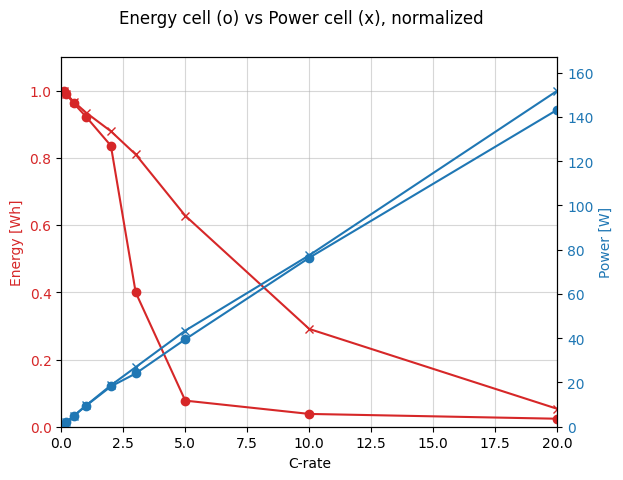

In [7]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_xlabel("C-rate")

styles = ["-o", "-x"]
for outputs, style in zip([outputs_energy_cell, outputs_power_cell], styles):
    # change y axis labels and color to blue
    ax.plot(outputs["C-rate"], outputs["Energy [Wh]"] / outputs["Energy [Wh]"][0], style, color="tab:red")
    ax.set_ylabel("Energy [Wh]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")
    ax.set_ylim(0, 1.1)

    # add a twin axis for time on a log scale
    ax2.plot(outputs["C-rate"], outputs["Power [W]"] / outputs["Power [W]"][0], style, color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Power [W]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])
    ax2.set_ylim(0, outputs["Power [W]"][-1] / outputs["Power [W]"][0] * 1.1)

ax.grid(alpha=0.5)


fig.suptitle("Energy cell (o) vs Power cell (x), normalized")
